In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Load the training and testing datasets
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [2]:
data_train = pd.read_csv("housing_train.csv")
data_test = pd.read_csv("housing_test.csv")
data_test_y = pd.read_csv("housing_test_y.csv")
data_test['SalePrice']=data_test_y['SalePrice']
data_train['train']=1
data_test['train']=0
data = pd.concat([data_train, data_test], axis=0, sort=False)
print('data_train.shape', data_train.shape)
print('data_test.shape', data_test.shape)
print('data.shape', data.shape)

data_train.shape (1460, 82)
data_test.shape (1459, 82)
data.shape (2919, 82)


In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


the regression target is SalePrice

In [4]:
data.head().SalePrice

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

## Handle missing values (NaN and None)


In [5]:
#show the missing values in a table
Missing = pd.concat([data_train.isnull().sum(), data_test.isnull().sum()], axis=1, keys=['Train', 'Test'],sort=False)
Missing[Missing.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4
LotFrontage,259,227
Alley,1369,1352
Utilities,0,2
Exterior1st,0,1
Exterior2nd,0,1
MasVnrType,8,16
MasVnrArea,8,15
BsmtQual,37,44
BsmtCond,37,45


<AxesSubplot:>

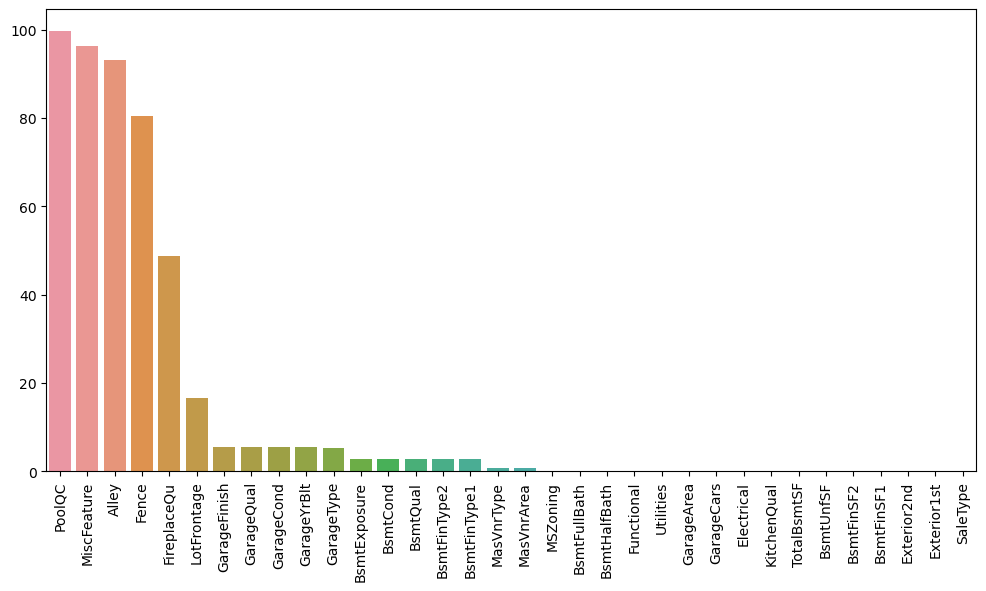

In [6]:
data_missing = (data.isnull().sum(axis=0)/data.shape[0]) * 100
data_missing = data_missing.drop(data_missing[data_missing == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90)
sns.barplot(x=data_missing.index, y=data_missing)

From the figure, we see that nearly 100% values of the feature/column 'PoolQC' are missing <br>
We can simply delete these features (drop these columns from the table) of which >=50% values are missing

In [7]:
feature_drop = data_missing[data_missing >=50].index
feature_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')

In [8]:
data=data.drop(columns=feature_drop)
data=data.drop(columns='Id')

In [9]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500.0,1
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500.0,1
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500.0,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,1
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000.0,1


For those features with < 50% missing values, we can use impute method. <br>
Missing numerical values can be imputed with a constant value, or some statistics (mean, median or most frequent) of each column in which the missing values are located. <br>
Missing categorical/non-numeric values can be imputed with the most frequent category, or a new category-'nothing'

In [10]:
numerical_column=[]
categorical_column=[]
for c in data.columns:
    v=data[c]
    v=v[~v.isnull()]
    if data[c].dtype == np.dtype('O'): # non-numeric values       
        data[c]=data[c].fillna('nothing') # a new category         
        categorical_column.append(c)
    else: # numeric 
        if c != 'train' and c != 'SalePrice':
            data[c]=data[c].fillna(v.median()) 
        numerical_column.append(c)        

check if there is any missing value

In [11]:
data[data.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train


convert categorical values to numerical values using one-hot encoding <br>
note: there are other methods to encode categorical values

In [12]:
data=pd.get_dummies(data, columns=categorical_column)
data.shape

(2919, 296)

In [13]:
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nothing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,0,0,0,0,0,1,0


### get training data and testing data from `data`

In [14]:
data_train = data[data['train']==1]
X_train=data_train.drop(columns=['SalePrice', 'train']).values
Y_train=data_train['SalePrice'].values

In [15]:
X_train.dtype

dtype('float64')

In [16]:
X_train.shape

(1460, 294)

In [17]:
Y_train.dtype

dtype('float64')

In [18]:
data_test = data[data['train']==0]
X_test=data_test.drop(columns=['SalePrice', 'train']).values
Y_test=data_test['SalePrice'].values

### Train a regression model to predict SalePrice

Text(0.5, 1.0, 'histogram of SalePrice in training set')

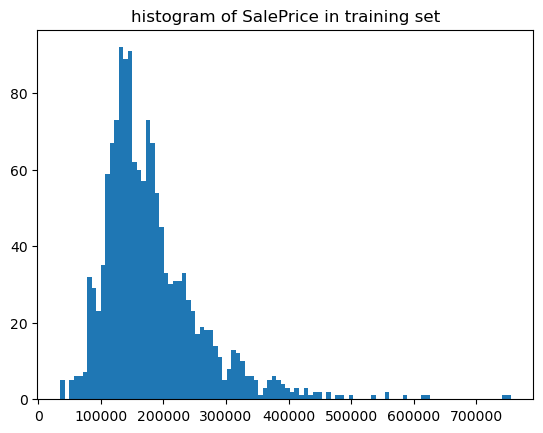

In [19]:
plt.hist(data_train.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in training set')

Text(0.5, 1.0, 'histogram of SalePrice in testing set')

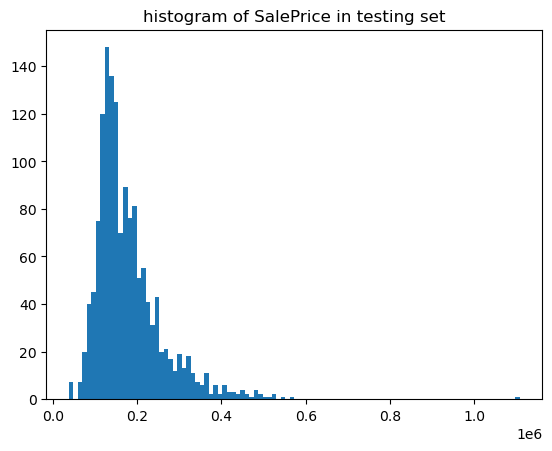

In [20]:
plt.hist(data_test.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in testing set')

### Predict SalePrice using a linear regression model

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

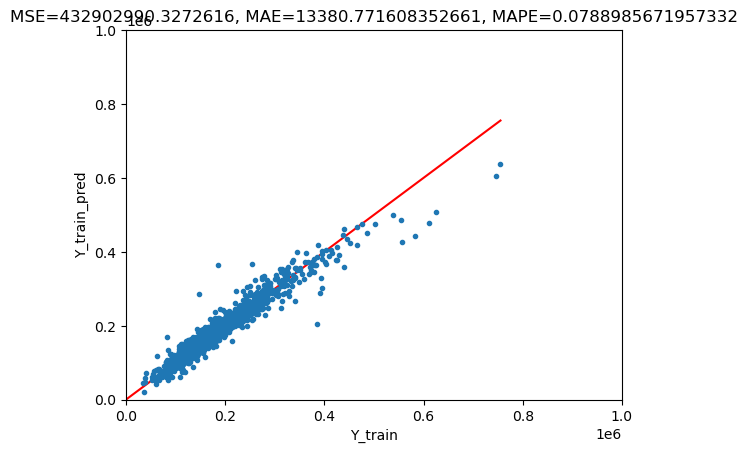

In [22]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

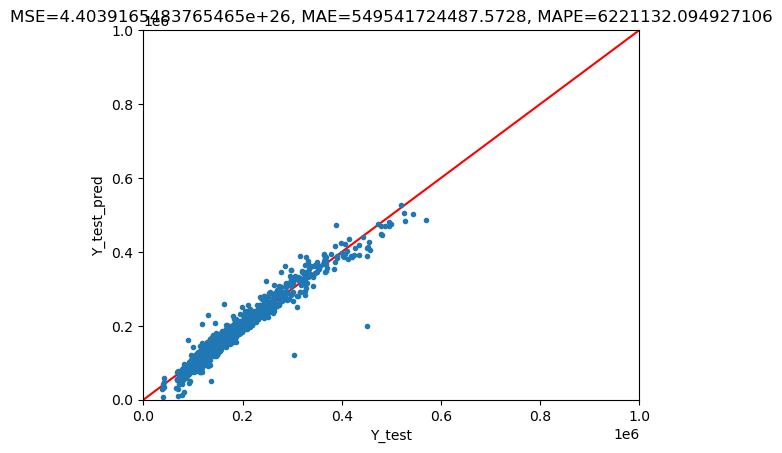

In [23]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

In [24]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

310

Perform 10-fold cross valiation to get the average MAPE (or other accuracy measurements)

In [25]:
def my_scorer(model, X, y):
    y_pred = model.predict(X)
    MAPE =  np.mean(np.abs(y_pred - y)/y)
    return MAPE
#
from sklearn.model_selection import cross_val_score
MAPE_array = cross_val_score(linear_model, X_train, Y_train, cv=10, scoring=my_scorer)
MAPE_array

array([1.11110523e-01, 1.05192741e-01, 1.07969484e-01, 1.92224334e+01,
       1.20892225e-01, 1.06193720e-01, 1.07316473e-01, 6.22845565e+00,
       4.27245714e+01, 1.71406834e+02])

#### KNeighborsRegressor

In [26]:
import numpy as np
from sklearn.metrics import make_scorer

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


The best n_neighbors is: 7 with a MAPE of: 0.17%


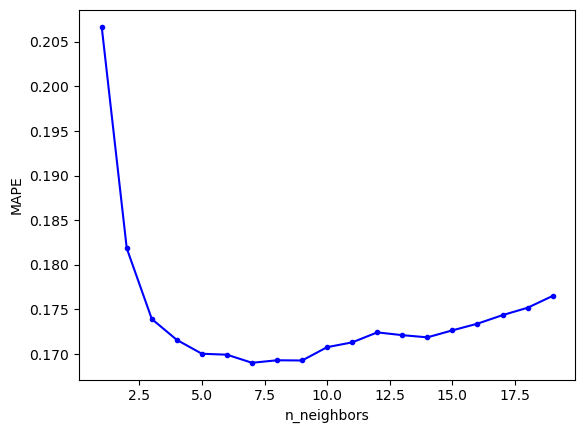

In [27]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

MAPE_average_list = []
hyperparameter_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 

for n_neighbors in hyperparameter_list:
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    MAPE_array = cross_val_score(knn, X_train, Y_train, cv=10, scoring=mape_scorer, n_jobs=4)
    MAPE_average_list.append(-MAPE_array.mean())
    
best_n_neighbors_index = np.argmin(MAPE_average_list)
best_n_neighbors = hyperparameter_list[best_n_neighbors_index]
best_MAPE = MAPE_average_list[best_n_neighbors_index]

print(f"The best n_neighbors is: {best_n_neighbors} with a MAPE of: {best_MAPE:.2f}%")

plt.plot(hyperparameter_list, MAPE_average_list, '.-b')
plt.xlabel('n_neighbors')
plt.ylabel('MAPE')
plt.show()

build a KNeighborsRegressor using the best hyperparameter <br>
fit it to the training data and test it on the testing data

In [28]:
best_n_neighbors = hyperparameter_list[np.argmin(MAPE_average_list)]

knn_best = KNeighborsRegressor(n_neighbors=best_n_neighbors)
knn_best.fit(X_train, Y_train)

from sklearn.metrics import mean_squared_error, mean_absolute_error

Y_train_pred = knn_best.predict(X_train)
Y_test_pred = knn_best.predict(X_test)

mse_train = mean_squared_error(Y_train, Y_train_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mape_train = mean_absolute_percentage_error(Y_train, Y_train_pred)

mse_test = mean_squared_error(Y_test, Y_test_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
mape_test = mean_absolute_percentage_error(Y_test, Y_test_pred)

show the training result

Training MSE: 1573480679.5853229, MAE: 24739.97299412916, MAPE: 0.14366371327647984


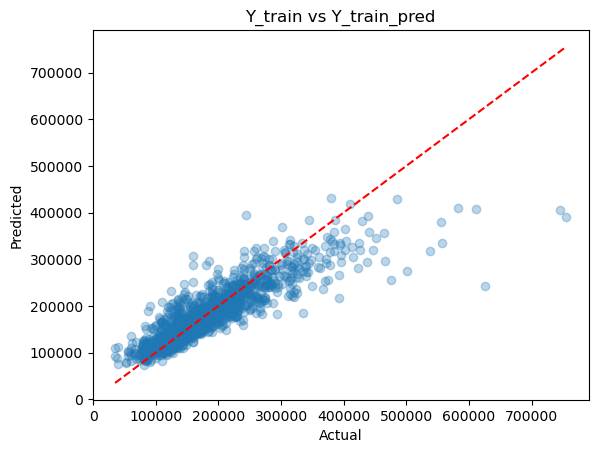

In [29]:
print(f'Training MSE: {mse_train}, MAE: {mae_train}, MAPE: {mape_train}')

plt.figure()
plt.scatter(Y_train, Y_train_pred, alpha=0.3)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Y_train vs Y_train_pred')
plt.show()

show the testing result

Testing MSE: 2010223312.7858474, MAE: 26345.20752791379, MAPE: 0.1530563282560168


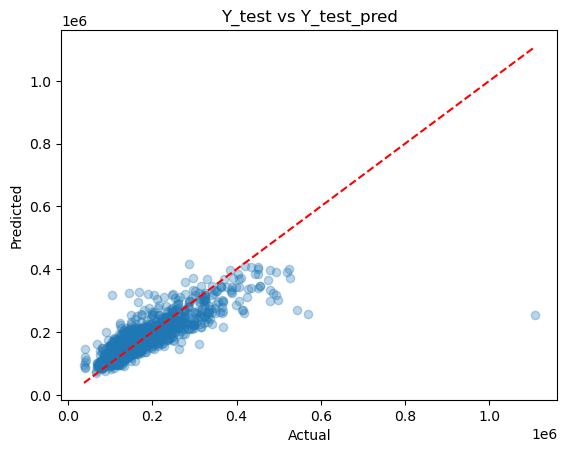

In [30]:
print(f'Testing MSE: {mse_test}, MAE: {mae_test}, MAPE: {mape_test}')

plt.figure()
plt.scatter(Y_test, Y_test_pred, alpha=0.3)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Y_test vs Y_test_pred')
plt.show()

#### RandomForestRegressor

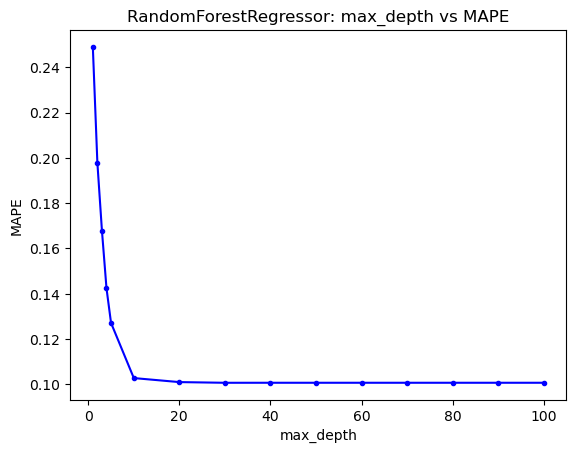

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np


MAPE_average_list = []
hyperparameter_list = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 


for max_depth in hyperparameter_list:
    rf = RandomForestRegressor(max_depth=max_depth, random_state=0, n_jobs=4)
    MAPE_array = cross_val_score(rf, X_train, Y_train, cv=10, scoring=mape_scorer, n_jobs=4)
    MAPE_average_list.append(-MAPE_array.mean())


plt.plot(hyperparameter_list, MAPE_average_list, '.-b')
plt.xlabel('max_depth')
plt.ylabel('MAPE')
plt.title('RandomForestRegressor: max_depth vs MAPE')
plt.show()


In [32]:
best_max_depth = hyperparameter_list[np.argmin(MAPE_average_list)]


rf_best = RandomForestRegressor(max_depth=best_max_depth, random_state=0, n_jobs=4)
rf_best.fit(X_train, Y_train)


Y_train_pred = rf_best.predict(X_train)
mse_train = mean_squared_error(Y_train, Y_train_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mape_train = mean_absolute_percentage_error(Y_train, Y_train_pred)

Y_test_pred = rf_best.predict(X_test)
mse_test = mean_squared_error(Y_test, Y_test_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
mape_test = mean_absolute_percentage_error(Y_test, Y_test_pred)

show the training result

Random Forest - Training MSE: 120889588.5922959, MAE: 6515.488123287671, MAPE: 0.037889456633245965


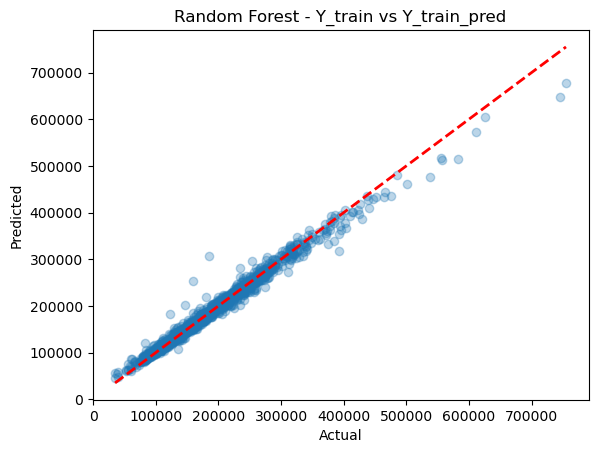

In [33]:
print(f'Random Forest - Training MSE: {mse_train}, MAE: {mae_train}, MAPE: {mape_train}')

plt.figure()
plt.scatter(Y_train, Y_train_pred, alpha=0.3)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest - Y_train vs Y_train_pred')
plt.show()

show the testing result

Random Forest - Testing MSE: 603320323.5518068, MAE: 10532.708084785683, MAPE: 0.059351612630727746


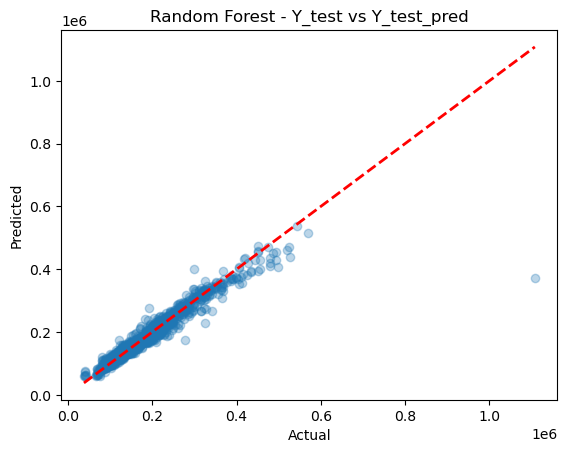

In [34]:
print(f'Random Forest - Testing MSE: {mse_test}, MAE: {mae_test}, MAPE: {mape_test}')

plt.figure()
plt.scatter(Y_test, Y_test_pred, alpha=0.3)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest - Y_test vs Y_test_pred')
plt.show()

In [36]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.3 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


#### XGBRegressor
https://anaconda.org/anaconda/py-xgboost

The best max_depth is: 40


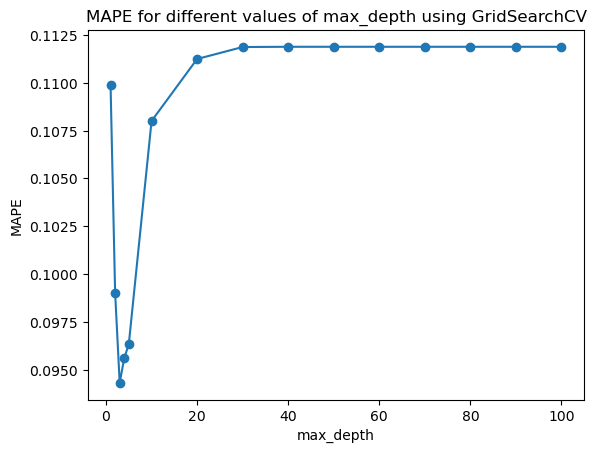

In [37]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import matplotlib.pyplot as plt

def my_scorer(model, X, y):
    y_pred = model.predict(X)
    MAPE =  np.mean(np.abs(y_pred - y)/y)
    return MAPE

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  
}

xgb_model = XGBRegressor(random_state=0, objective='reg:squarederror')

grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    scoring=my_scorer, 
    cv=10, 
    n_jobs=4  
)


grid_search.fit(X_train, Y_train)


best_max_depth = grid_search.best_params_['max_depth']
print(f"The best max_depth is: {best_max_depth}")


best_xgb_model = grid_search.best_estimator_


scores = grid_search.cv_results_['mean_test_score']
plt.plot(param_grid['max_depth'], scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('MAPE')
plt.title('MAPE for different values of max_depth using GridSearchCV')
plt.show()


build a XGBRegressor using the best hyperparameter and fit it to the training data

In [38]:
best_model = XGBRegressor(max_depth=best_max_depth, random_state=0, objective='reg:squarederror')
best_model.fit(X_train, Y_train)


Y_train_pred = best_model.predict(X_train)


Y_test_pred = best_model.predict(X_test)


from sklearn.metrics import mean_squared_error, mean_absolute_error

MSE_train = mean_squared_error(Y_train, Y_train_pred)
MAE_train = mean_absolute_error(Y_train, Y_train_pred)
MAPE_train = np.mean(np.abs((Y_train - Y_train_pred) / Y_train))

MSE_test = mean_squared_error(Y_test, Y_test_pred)
MAE_test = mean_absolute_error(Y_test, Y_test_pred)
MAPE_test = np.mean(np.abs((Y_test - Y_test_pred) / Y_test))

show the training result

Training Set: MSE = 0.00037261753866117296, MAE = 0.014910637842465753, MAPE = 8.03589069600684e-08


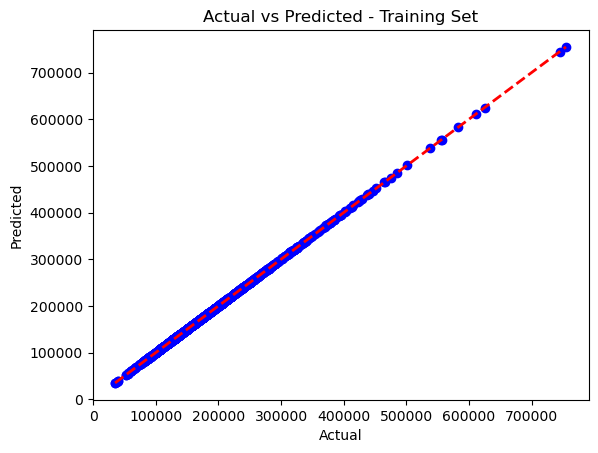

In [39]:
print(f"Training Set: MSE = {MSE_train}, MAE = {MAE_train}, MAPE = {MAPE_train}")

plt.scatter(Y_train, Y_train_pred, color='blue')
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Training Set')
plt.show()

show the testing result

Testing Set: MSE = 773025650.6913805, MAE = 13650.059375800036, MAPE = 0.07691666786571179


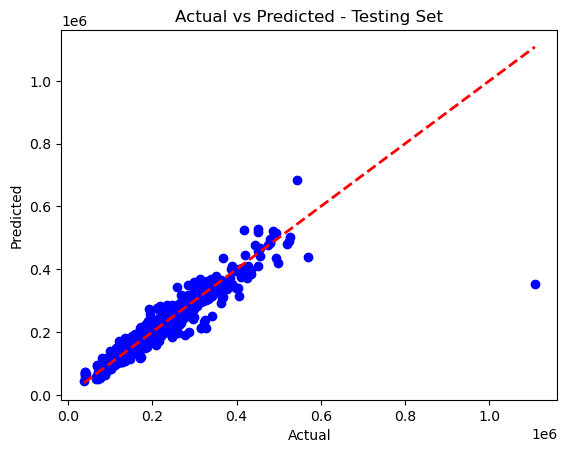

In [40]:
print(f"Testing Set: MSE = {MSE_test}, MAE = {MAE_test}, MAPE = {MAPE_test}")

plt.scatter(Y_test, Y_test_pred, color='blue')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Testing Set')
plt.show()

In [41]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

368